# Datset Source
1. cifar10 - https://www.cs.toronto.edu/~kriz/cifar.html

# Hyperparameters

In [62]:
EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.001

#  Download and Load the CIFAR-10 Dataset

In [63]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [64]:
# Define transformation (normalization and data augmentation)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [65]:
# Load CIFAR-10 data (train and test sets)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [66]:
# Create DataLoader for training and testing
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

# Exploratory Data Analysis (EDA)

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [68]:
# Visualize random images
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()     # Convert to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [69]:
# Get class names and visualize random sample images
classes = trainset.classes

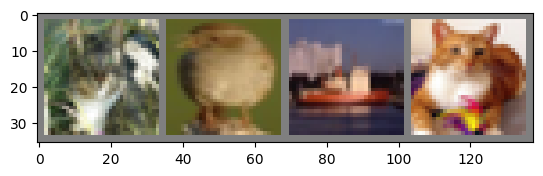

In [70]:
# Show a few random images
dataiter = iter(trainloader)  # Create an iterator from the DataLoader
images, labels = next(dataiter)  # Get the first batch of data
imshow(torchvision.utils.make_grid(images[:4]))  # Show 4 random images

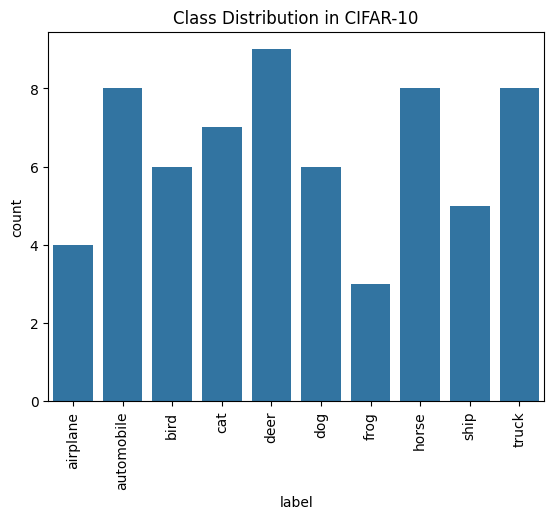

In [71]:
# Create a dataframe to explore class distribution
df = pd.DataFrame(labels.numpy(), columns=["label"])
sns.countplot(x="label", data=df)
plt.title("Class Distribution in CIFAR-10")
plt.xticks(np.arange(10), classes, rotation=90)
plt.show()

# Custom Data Processing Pipeline using PyTorch

In [72]:
from torch.utils.data import Dataset
from PIL import Image

In [73]:
class CustomCIFAR10(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.dataset = torchvision.datasets.CIFAR10(root=root, train=train, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [74]:
# Example of a custom transform (additional augmentations can go here)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [75]:
# Create custom data loader
trainset = CustomCIFAR10(root='./data', train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Build the Classification Model

In [76]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [77]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128*8*8, 512)
        self.fc2 = nn.Linear(512, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, 128*8*8)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Prepare Training using PyTorch Lightning

In [78]:
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models

class ResNetCIFAR10(pl.LightningModule):
    def __init__(self, num_classes=10):
        super(ResNetCIFAR10, self).__init__()
        
        # Load pre-trained ResNet-18
        self.model = models.resnet18(pretrained=True)
        
        # Modify the last fully connected (FC) layer for 10 classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        # Define loss function
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return [optimizer], [scheduler]

In [79]:
# Instantiate model
model = ResNetCIFAR10(num_classes=10)

f:\bongoDev ML Course\000.Exercises\image_classifier\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\bongoDev ML Course\000.Exercises\image_classifier\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ADMIN/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [02:47<00:00, 280kB/s] 


# Callbacks

In [80]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [81]:
# Define callbacks (checkpointing and early stopping)
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1)


In [82]:
# Define EarlyStopping callback
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=True)

# Train

In [83]:
# Initialize trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[checkpoint_callback, early_stopping],
    accelerator="cpu",  # Change to "gpu" if you have GPU
    devices=1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Track Experiments using MLFlow

In [84]:
import mlflow
import shutil
import os
from mlflow.models.signature import infer_signature
from torchvision import transforms

In [85]:
# Set the tracking directory
#mlflow_tracking_uri = os.path.join(os.getcwd(), "mlruns")

In [86]:
# Ensure the tracking directory exists
# if not os.path.exists(mlflow_tracking_uri):
#     os.makedirs(mlflow_tracking_uri)

In [87]:
# Set MLFlow tracking URI
# mlflow.set_tracking_uri(f"file://{mlflow_tracking_uri}")

In [88]:
# Start MLFlow experiment tracking
mlflow.set_experiment("CIFAR-10_ResNet")

2025/02/02 13:21:34 INFO mlflow.tracking.fluent: Experiment with name 'CIFAR-10_ResNet' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///f:/bongoDev%20ML%20Course/000.Exercises/image_classifier/mlruns/408912435176137303', creation_time=1738480894503, experiment_id='408912435176137303', last_update_time=1738480894503, lifecycle_stage='active', name='CIFAR-10_ResNet', tags={}>

In [89]:

# Define the artifact folder to save the model
ARTIFACT_FOLDER_NAME = "model"
# Save the source code path for logging later
SOURCE_CODE_PATH = os.path.join(os.getcwd(), "model_build.ipynb")
SOURCE_CODE_ARTIFACT = "train_cifar10.ipynb"

In [91]:
# Start MLFlow experiment tracking
with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("epochs", 15)
    mlflow.log_param("lr", 0.001)
    mlflow.log_param("batch_size", 64)

    # Train model
    trainer.fit(model, train_dataloaders=trainloader, val_dataloaders=testloader)

    # Evaluate best model
    evaluation_score = trainer.test(model, dataloaders=testloader)

    # Log test metrics
    mlflow.log_metric("test_accuracy", evaluation_score[0]['test_acc'])
    mlflow.log_metric("test_loss", evaluation_score[0]['test_loss'])

    # Save model
    pixels_batch = next(iter(testloader))[0].cpu().numpy()
    signature = infer_signature(pixels_batch)

    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path="model",
        registered_model_name="cifar10_resnet_classifier",
        signature=signature
    )

    shutil.copyfile(SOURCE_CODE_PATH, SOURCE_CODE_ARTIFACT)
    mlflow.log_artifact(SOURCE_CODE_ARTIFACT)

f:\bongoDev ML Course\000.Exercises\image_classifier\venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory f:\bongoDev ML Course\000.Exercises\image_classifier\lightning_logs\version_2\checkpoints exists and is not empty.

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 11.2 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.60it/s]    
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.848800003528595
        test_loss           0.46899500489234924
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Registered model 'cifar10_resnet_classifier' already exists. Creating a new version of this model...
Created version '2' of model 'cifar10_resnet_classifier'.


In [92]:
# Print MLFlow UI command for viewing the experiment
print(f"mlflow ui --backend-store-uri {mlflow.get_tracking_uri()}")

mlflow ui --backend-store-uri file:///f:/bongoDev%20ML%20Course/000.Exercises/image_classifier/mlruns
